# Arithmetic

In [2]:
from tasks.arithmetic import Arithmetic
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
import matplotlib
import utils
import train_bitmap
import train_arithmetic

from importlib import reload

In [6]:
config = utils.DotDict(yaml.safe_load(open('experiments/arithmetic/ntm/config.yaml')))

# customize config
config.load = 'experiments/arithmetic/ntm/checkpoints/NTM-200000.pth'

In [7]:
id_to_char = ['0', '1', '+', '#']

def generate_example(x, example_len):
    s = ''
    _, idx = x[0,:example_len].max(1)
    for elem in idx:
        s += id_to_char[elem.item()]
    return s


def generate_answer(y, example_len):
    s = ''
    _, idx = y[0, example_len+1:].max(1)
    for elem in idx:
        s += id_to_char[elem.item()]
        if elem.item() == 3:
            return s
    return s


def to_dec(s):
    if s.find('+') == -1:
        return str(int(s, 2))
    s1, s2 = s.split('+')
    return to_dec(s1) + '+' + to_dec(s2)


def evaluate(x, y, model, example_len, debug=None):
    ex = generate_example(x, example_len)
    answ = generate_answer(y, example_len)
    print(ex + '=' + answ)
    print(to_dec(ex) + '=' + to_dec(answ[:-1]))
    pred = model(x.cuda())    
    str_pred = generate_answer(pred, example_len)
    print('binary pred:', str_pred)
    #print('decimal pred:', to_dec(str_pred[:-1]))
    return pred
    
def random_example(ex_len):
    x, y, m = train_data.gen_batch(batch_size=1,
                min_len=ex_len, max_len=ex_len,
                distribution=np.array([1,]))
    return evaluate(x, y, model, ex_len)

In [8]:
model, optimizer, loss, train_data, validation_data = train_arithmetic.setup_model(config)

In [14]:
ex_len = 7
x, y, m = train_data.gen_batch(batch_size=1,
                min_len=ex_len, max_len=ex_len,
                distribution=np.array([1,]))
evaluate(x, y, model, ex_len)
info = {}
pred = model(x.cuda(), info)

0+10010=10010#
0+18=18
binary pred: 10010#


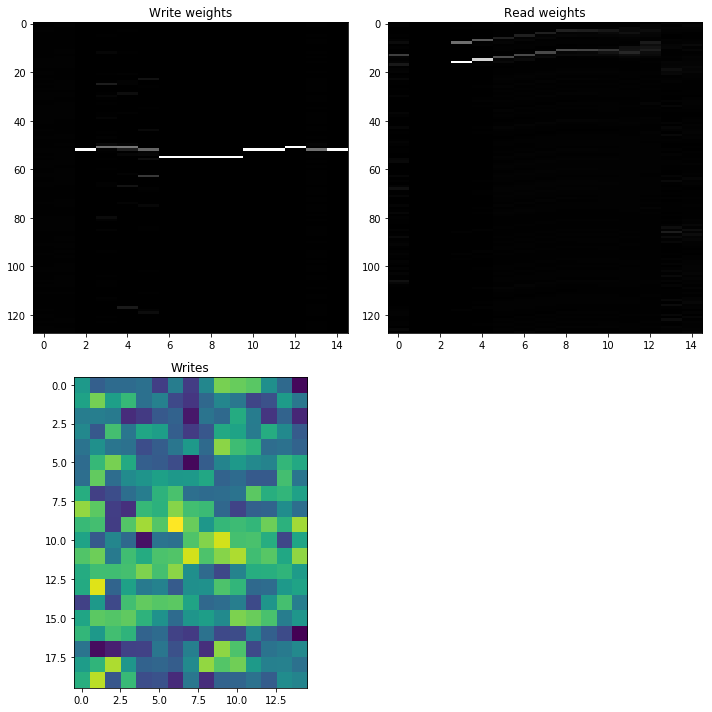

In [15]:
write_weights = np.array([w.squeeze().detach().cpu().numpy() for w in info['write_head']['write_weights']])
read_weights = np.array([w.squeeze().detach().cpu().numpy() for w in info['read_head']['read_weights']])
writes = np.array([w.squeeze().detach().cpu().numpy() for w in info['write_head']['write_vectors']])
                                                                                  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.title('Write weights')
plt.imshow(write_weights.T, cmap='gray', aspect='auto')

plt.subplot(222)
plt.title('Read weights')
plt.imshow(read_weights.T, cmap='gray', aspect='auto')

plt.subplot(223)
plt.title('Writes')
plt.imshow(writes.T, aspect='equal')

plt.tight_layout()
plt.show()

# Plots NTM/DNC

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib2tikz

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [205]:
def extract_scalars(experiment):
    result = defaultdict(lambda: defaultdict(list))
    p = Path("experiments")/experiment/"tensorboard"
    for s in p.glob("seed_*"):
        seed = s.name.split("_")[-1]
        event = EventAccumulator(str(s))
        event.Reload()
        for tag in event.Tags()['scalars']:
            for scalar in event.Scalars(tag):
                result[seed][tag].append([scalar.step, scalar.value])
            result[seed][tag] = pd.DataFrame(result[seed][tag], columns=['step', 'value'])
    return result
    

In [228]:
def plot_train_cost(costs, title, export):
    plt.figure(figsize=(15, 5))
    lengths = list(map(len, costs))
    min_len = lengths.index(min(lengths))
    max_len = lengths.index(max(lengths))

    for i, d in enumerate(costs):
        if i != min_len and i != max_len:
            plt.plot(d.step, d.value.rolling(50).mean(), color='gray', linestyle='--', label='_nolegend_')
    
    plt.plot(costs[max_len].step, costs[max_len].value.rolling(20).mean(), color='red', label='Worst')
    plt.plot(costs[max_len].step, costs[max_len].value, 'red', alpha=0.3, label='_nolegend_')

    plt.plot(costs[min_len].step, costs[min_len].value.rolling(20).mean(), color='green', label='Best')
    plt.plot(costs[min_len].step, costs[min_len].value, 'green', alpha=0.3, label='_nolegend_')
            
    plt.title(title)
    plt.xlabel('Sequence')
    plt.ylabel('Error (bits)')
    plt.legend()
    matplotlib2tikz.save(export)

In [229]:
# NTM Copy
ntm_copy = extract_scalars("copy/ntm")

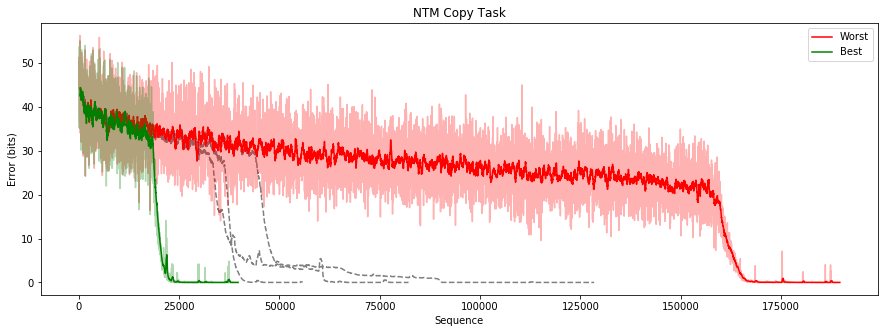

In [230]:
plot_train_cost([s["train/cost"] for s in ntm_copy.values()], "NTM Copy Task", "/Users/irubachev/ntm_copy.tex")

In [214]:
!ls experiments/copy

dnc_dropnorm             dnc_masking              lstm
dnc_dropnorm_full_memory dnc_memory_limited       ntm
dnc_link_problem         dnc_standart


In [235]:
dnc_copy = extract_scalars("copy/dnc_masking")

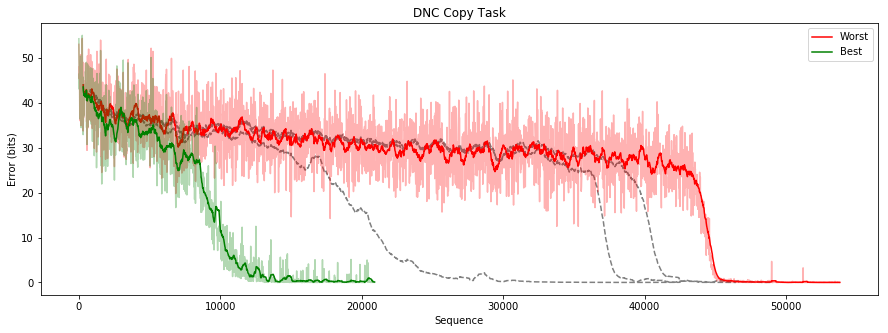

In [232]:
plot_train_cost([s["train/cost"] for s in dnc_copy.values()], "DNC Copy Task", "/Users/irubachev/dnc_copy.tex")

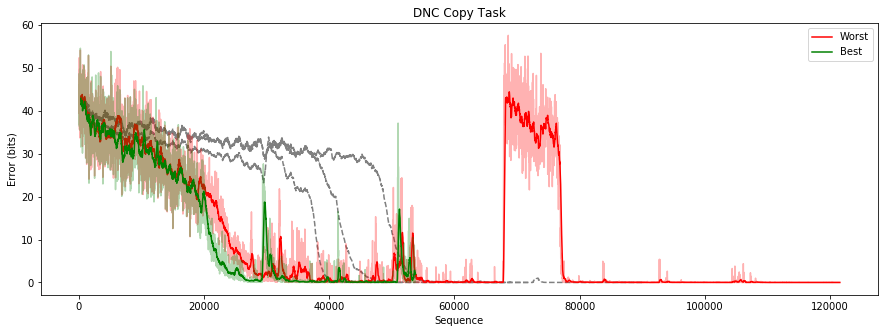

In [234]:
plot_train_cost([s["train/cost"] for s in dnc_copy.values()], "DNC Copy Task", "/Users/irubachev/dnc_copy.tex")

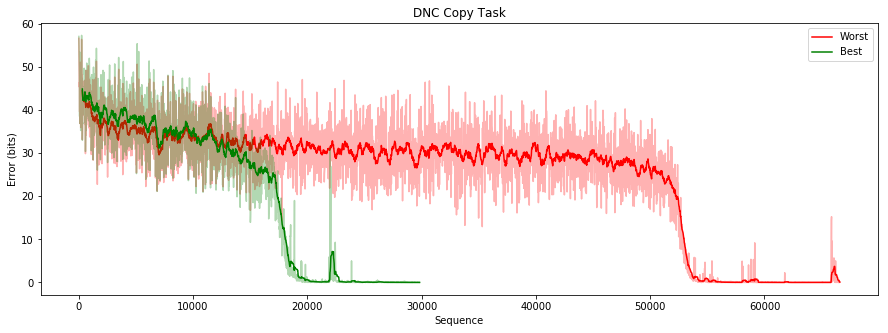

In [236]:
plot_train_cost([s["train/cost"] for s in dnc_copy.values()], "DNC Copy Task", "/Users/irubachev/dnc_copy.tex")